In [1]:
import re, glob,os
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from astropy.coordinates import SkyCoord
from plotly.subplots import make_subplots

In [2]:
def in_colab():
    try:
        import google.colab
        print('You are in Google Collab')
        return True
    except ImportError:
        return False

if in_colab():
    print('Adding data to repository')
    repo_url = "https://github.com/Fink-analyses/Tutorial_LSST_sims_2025.git"
    repo_name = "Tutorial_LSST_sims_2025"
    
    if not os.path.exists(repo_name):
        print("Cloning repo...")
        !git clone $repo_url
    
    # cd only if not already inside
    current_path = os.path.basename(os.getcwd())
    if current_path != repo_name:
        %cd $repo_name


# Useful definitions

In [3]:
# Useful functions
def convert_fluxcal_to_mag(df):
    """Convert fluxcal to magnitude and add magnitude error

    Args:
        df (pd.DataFrame): DataFrame with columns "FLUXCAL" and "FLUXCALERR"
    Returns:
        pd.DataFrame: DataFrame with added "magnitude" and "magnitude error"
    """
    # Convert fluxcal to magnitude
    df = df.copy()
    flux = df["FLUXCAL"].copy()
    flux[flux <= 0] = np.nan

    # Compute magnitude; where flux was <= 0, magnitude will be NaN
    df["magnitude"] = -2.5 * np.log10(flux) + 27.5
    df["magnitude error"] = 2.5 / np.log(10) * df["FLUXCALERR"] / df["FLUXCAL"]
    return df

def read_fits(fname, drop_separators=False):
    """Load SNANA formatted data and cast it to a PANDAS dataframe

    Args:
        fname (str): path + name to PHOT.FITS file
        drop_separators (Boolean): if -777 are to be dropped

    Returns:
        (pandas.DataFrame) dataframe from PHOT.FITS file (with ID)
        (pandas.DataFrame) dataframe from HEAD.FITS file
    """

    # load photometry
    dat = Table.read(fname, format="fits")
    df_phot = dat.to_pandas()
    # failsafe
    if df_phot.MJD.values[-1] == -777.0:
        df_phot = df_phot.drop(df_phot.index[-1])
    if df_phot.MJD.values[0] == -777.0:
        df_phot = df_phot.drop(df_phot.index[0])

    # load header
    header = Table.read(fname.replace("PHOT", "HEAD"), format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)
    folder = os.path.basename(os.path.dirname(fname))
    # Add new column with this extracted SN type for all rows
    df_header['SN_TYPE_FROM_PATH'] = folder

    # add SNID to phot for skimming
    arr_ID = np.zeros(len(df_phot), dtype=np.int32)
    # New light curves are identified by MJD == -777.0
    arr_idx = np.where(df_phot["MJD"].values == -777.0)[0]
    arr_idx = np.hstack((np.array([0]), arr_idx, np.array([len(df_phot)])))
    # Fill in arr_ID
    for counter in range(1, len(arr_idx)):
        start, end = arr_idx[counter - 1], arr_idx[counter]
        # index starts at zero
        arr_ID[start:end] = df_header.SNID.iloc[counter - 1]
    df_phot["SNID"] = arr_ID

    if drop_separators:
        df_phot = df_phot[df_phot.MJD != -777.000]

    df_phot['SNR'] = df_phot['FLUXCAL'] / df_phot['FLUXCALERR']

    # Add a column for latest MJD per SNID where SNR > 5
    df_max_mjd = (
    df_phot[df_phot.SNR > 5]
    .groupby('SNID', as_index=False)['MJD']
    .max()
    .rename(columns={'MJD': 'max_MJD_SNR_gt_5'})
    )
    df_phot_with_last_mjd = df_phot.copy()
    df_phot_with_last_mjd = df_phot_with_last_mjd.merge(df_max_mjd,on='SNID')

    # convert to magnitude
    df_phot_with_last_mjd = convert_fluxcal_to_mag(df_phot_with_last_mjd)

    df_header_with_DDF = tag_DDF(df_header)

    return df_header_with_DDF, df_phot_with_last_mjd



def tag_DDF(df_header):
    """Tag DDF fields in the header DataFrame
    Approximation using a 3 degree radius around the field center.

    Args:
        df_header (pd.DataFrame): DataFrame with header information

    Returns:
        pd.DataFrame: Updated df_header with DDF field tags
    """

    # Rubin DDFs coordinates
    dff_coords_dic = {
        'Field': ['ELAISS1', 'XMM_LSS', 'ECDFS', 'COSMOS', 'EDFS_a', 'EDFS_b'],
        'RA': [9.45, 35.57, 52.98, 150.11, 58.9, 63.6],
        'DEC': [-44.02, -4.82, -28.12, 2.23, -49.32, -47.6],
        'Gal l': [311.29, 171.1, 224.07, 236.78, 257.9, 254.48],
        'Gal b': [-72.88, -58.91, -54.6, 42.13, -48.46, -45.77],
        'Eclip l': [346.66, 31.59, 40.81, 151.39, 32, 40.97],
        'Eclip b': [-43.2, -17.92, -45.44, -9.34, -66.61, -66.6]
    }

    ddf_fields = pd.DataFrame(dff_coords_dic)
    
    # Initialize new columns[]
    df_header["in_ddf_field"] = False
    df_header["ddf_field_name"] = np.nan

    # Convert df_header RA/DEC to SkyCoord
    coords_header = SkyCoord(ra=df_header["RA"].values * u.deg,
                            dec=df_header["DEC"].values * u.deg)

    # Loop through DDF fields
    for _, row in ddf_fields.iterrows():
        field = row["Field"]
        ra = row["RA"]
        dec = row["DEC"]
        
        # Convert field center to SkyCoord
        field_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
        
        # Compute angular separation
        separation = coords_header.separation(field_coord)
        
        # Find objects within radius (approximation of cirdular footprint)
        radius = 3 # degrees
        within = separation <= radius * u.deg
        
        df_header.loc[within, "in_ddf_field"] = True
        df_header.loc[within, "ddf_field_name"] = field
    return df_header


# Read simulations

In [4]:
df_header_list=[]
df_phot_list=[]
list_to_read = glob.glob("sims/*/*PHOT.FITS.gz")
print(f"Found {len(list_to_read)} PHOT.FITS.gz files to read.")
for fphot in list_to_read:
    print(f"Reading {fphot}")
    df_header_tmp, df_phot_tmp = read_fits(fphot, drop_separators=True)
    df_header_list.append(df_header_tmp)
    df_phot_list.append(df_phot_tmp)
df_header = pd.concat(df_header_list, ignore_index=True)
# Read all PHOT.FITS.gz files and concatenate them    
df_phot = pd.concat(df_phot_list, ignore_index=True)

print("")
print(f"Number of light curves: {len(df_header)}")
print(f"Number of photometric points per light-curve: {df_phot.groupby('SNID').count()['MJD'].median()} +- {np.round(df_phot.groupby('SNID').count()['MJD'].std(),2)}")
# Total per SNTYPE
total_counts = df_header.groupby('SN_TYPE_FROM_PATH')['SNID'].count()

# In DDF per SNTYPE
ddf_counts = df_header[df_header['in_ddf_field']].groupby('SN_TYPE_FROM_PATH')['SNID'].count()

# Combine into a DataFrame
summary_df = pd.DataFrame({
    'Total': total_counts,
    'In DDF': ddf_counts,
})

# Fill missing DDF entries with 0
summary_df['In DDF'] = summary_df['In DDF'].fillna(0).astype(int)

# Compute percentage
summary_df['% in DDF'] = (summary_df['In DDF'] / summary_df['Total'] * 100).round(1)

# Display
print(summary_df)


Found 9 PHOT.FITS.gz files to read.
Reading sims/AGN/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIIn/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIc/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIb/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SLSN/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/KN/PIP_AMR_KN_LSST_KN_KASEN_81c4b_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNII/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIa/AMR_ELASTICC2_LSST_NONIaMODEL00-0012_PHOT.FITS.gz
Reading sims/TDE/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz

Number of light curves: 68483
Number of photometric points per light-curve: 75.0 +- 257.3
                   Total  In DDF  % in DDF
SN_TYPE_FROM_PATH                         
AGN                 1241      13       1.0
KN                  5764      60       1.0
SLSN                 880      11       1.2
SNII               13991     303     

# Visualize simulated light-curves

In [5]:
# Useful plotting functions
band_colors = {
    'LSST-u': '#8c8cff',   # soft violet
    'LSST-g': '#377eb8',   # blue
    'LSST-r': '#4daf4a',   # green
    'LSST-i': '#ff7f00',   # orange
    'LSST-z': '#e41a1c',   # red
    'LSST-Y': '#a65628'    # brown
}

def plot_lc(df_phot, df_header, idx, inmag=False, convert_date=False):
    """Plot light curve for a given SNID

    Args:
        df_phot (pd.DataFrame): photometry
        df_header (pd.DataFrame): metadata
        idx (int64): SNID to plot
        inmag (bool, optional): Plot using magnitudes instead of FLUXCAL. Defaults to False.
        convert_date (bool, optional): Plot using human-dates instead of MJD. Defaults to False.
    """
    # Select data for the given SNID
    sel_phot = df_phot[df_phot.SNID == idx]
    sel_header = df_header[df_header.SNID == idx]

    if inmag: # selet only valid magnitudes
        sel_phot = sel_phot[sel_phot["magnitude"] > 0]
        yvar = "magnitude"
        yerrvar = "magnitude error"
    else:
        yvar = "FLUXCAL"
        yerrvar = "FLUXCALERR"

    ylabel = 'magnitude' if inmag else 'FLUXCAL'
    sel_phot["BAND"] = sel_phot["BAND"].str.decode('utf-8').str.strip()
    bands = sel_phot["BAND"].unique()

    # Convert MJD to datetime if requested
    if convert_date:
        sel_phot["TIME"] = pd.to_datetime(sel_phot["MJD"], unit='D', origin='1858-11-17')
        x_col = "TIME"
    else:
        x_col = "MJD"

    # Initialize the figure
    fig = go.Figure()
    for flt in bands:
        sel_phot_flt = sel_phot[sel_phot["BAND"] == flt]

        # Plot points based on SNR thresholds
        for snr_min, snr_max, symbol, opacity, name_suffix in [
            (5, np.inf, 'circle', 1, "SNR > 5"),
            (1, 5, 'square', 0.5, "1 < SNR < 5"),
        ]:
            mask = (sel_phot_flt['SNR'] > snr_min) & (sel_phot_flt['SNR'] < snr_max)
            fig.add_trace(go.Scatter(
                x=sel_phot_flt.loc[mask, x_col],
                y=sel_phot_flt.loc[mask, yvar],
                error_y=dict(
                    type='data',
                    array=sel_phot_flt.loc[mask, yerrvar],
                    visible=True,
                    thickness=1.5 if snr_min < 5 else None,
                    width=0.5 if snr_min < 5 else None,
                ),
                mode='markers',
                name=f"{flt}" if snr_min == 5 else None,
                showlegend=(snr_min == 5),  # hides legend when name is None
                marker=dict(opacity=opacity, symbol=symbol, size=8, color=band_colors.get(flt, 'black'))
            ))

        # SNR < 1 points, no error bars
        mask = sel_phot_flt['SNR'] < 1
        fig.add_trace(go.Scatter(
            x=sel_phot_flt.loc[mask, x_col],
            y=sel_phot_flt.loc[mask, yvar],
            mode='markers',
            name=None,
            showlegend=False,
            marker=dict(opacity=0.5, symbol='triangle-down', size=8,color=band_colors.get(flt, 'black'))
        ))

    z = np.round(float(sel_header.REDSHIFT_FINAL.values[0]), 2)
    sim_type_name = sel_header.SIM_TYPE_NAME.values[0]
    if isinstance(sim_type_name, bytes):
        sim_type_name = sim_type_name.decode("utf-8")
    if sel_header.in_ddf_field.values[0]:
        ddf_field_name = sel_header.ddf_field_name.values[0]
    else:
        ddf_field_name = "Not in DDF"
    fig.update_layout(
        title=f"{sim_type_name} SNID: {idx} z: {z} {ddf_field_name}",
        xaxis_title="Date" if convert_date else "MJD",
        yaxis_title=ylabel,
        height=300,
        width=600,
        legend_title="Filter"
    )

    if inmag:
        fig.update_yaxes(autorange="reversed")
    fig.show()


In [6]:
print("Plotting light curves for each SN type with >5 photometric points...")
print("Circles = SNR > 5, Squares = 1 < SNR < 5, Triangles = SNR < 1")
for sn_type in df_header['SN_TYPE_FROM_PATH'].unique():
    # Get SNIDs of this type
    snids = df_header[df_header['SN_TYPE_FROM_PATH'] == sn_type]['SNID'].values
    
    # Loop over SNIDs until one has >5 photometric points
    for idx in snids:
        if len(df_phot[df_phot['SNID'] == idx]) > 5:
            print(f"Plotting SN_TYPE {sn_type}, SNID {idx}")
            plot_lc(df_phot, df_header, idx, inmag=True, convert_date=True)
            break  # Stop after first successful plot
    else:
        print(f"No suitable SNID with >5 points found for type {sn_type}")


Plotting light curves for each SN type with >5 photometric points...
Circles = SNR > 5, Squares = 1 < SNR < 5, Triangles = SNR < 1
Plotting SN_TYPE AGN, SNID 6045747


Plotting SN_TYPE SNIIn, SNID 44803916


Plotting SN_TYPE SNIc, SNID 2998840


Plotting SN_TYPE SNIb, SNID 79368465


Plotting SN_TYPE SLSN, SNID 3722190


Plotting SN_TYPE KN, SNID 596


Plotting SN_TYPE SNII, SNID 41400187


Plotting SN_TYPE SNIa, SNID 56960148


Plotting SN_TYPE TDE, SNID 7864643


# Simulation vs alerts

Simulated light-curves require only that the object is detectable by Rubin

Alert stream to be received by brokers will contain:
1. first Signal-to-noise ratio >5 (SNR>5) detection
2. after a day from the first SNR>5, if there is another SNR>5 detection, forced photometry will be added to the new alert.
3. all subsequent SNR>5 detections plus forced photometry.

In [7]:
# In the reading function, we added a column with the last MJD with SNR > 5 per SNID
df_phot_in_stream = df_phot[df_phot['MJD'] <= df_phot['max_MJD_SNR_gt_5']]
df_head_in_stream = df_header[df_header['SNID'].isin(df_phot_in_stream['SNID'].unique())]

In [8]:
# How many events are we loosing since they didnt get to SNID>5?
print(f"Generated light-curves {len(df_header)}")
print(f"Number of light curves with in alert stream (SNR > 5): {len(df_phot_in_stream.groupby('SNID').count())}")
print("")
print(f"{(len(df_header)-len(df_phot_in_stream.groupby('SNID').count()))/len(df_header):.2%} unique events are not sent into stream as they don't achieve SNR>5")
print("")
# by type
# Get total number of unique events per type
total_per_type = df_header.groupby('SN_TYPE_FROM_PATH')['SNID'].nunique()
# Get the set of SNIDs that have at least one point with SNR > 5
snids_with_snr = df_phot[df_phot.SNR > 5]['SNID'].unique()
# Filter df_header to keep only SNIDs not in snids_with_snr
no_snr_df = df_header[~df_header['SNID'].isin(snids_with_snr)]
# Count how many per type have no SNR > 5
no_snr_per_type = no_snr_df.groupby('SN_TYPE_FROM_PATH')['SNID'].nunique()
# Combine into a single DataFrame for easier viewing
result = ((no_snr_per_type / total_per_type) * 100).fillna(0).sort_values(ascending=False)

# Print nicely
print("Percentage of unique events NOT sent into stream by type:")
for sn_type, frac in result.items():
    print(f"{frac:.2f}% of {sn_type}")


Generated light-curves 68483
Number of light curves with in alert stream (SNR > 5): 55741

18.61% unique events are not sent into stream as they don't achieve SNR>5

Percentage of unique events NOT sent into stream by type:
92.99% of KN
17.10% of SNII
16.76% of AGN
12.50% of SNIb
11.09% of SNIc
10.44% of SNIa
8.91% of TDE
7.57% of SNIIn
2.73% of SLSN


Median number of SNR>5 detections per type:
SN_TYPE_FROM_PATH
AGN      17.0
KN        2.0
SLSN     20.0
SNII      4.0
SNIIn     6.0
SNIa      4.0
SNIb      5.0
SNIc      5.0
TDE       8.0
Name: n_SNR5, dtype: float64


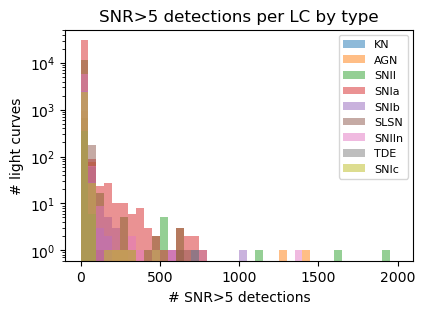

In [9]:
# Filter SNR > 5
snr5 = df_phot[df_phot.SNR > 5]

# Count SNR > 5 detections per SNID
snr_counts = snr5.groupby('SNID').count()['MJD'].reset_index()
snr_counts.rename(columns={'MJD': 'n_SNR5'}, inplace=True)

# Add SN_TYPE_FROM_PATH info
snr_counts = snr_counts.merge(df_header[['SNID', 'SN_TYPE_FROM_PATH']], on='SNID', how='left')

# Set color map
colors = plt.cm.tab10.colors
types = snr_counts['SN_TYPE_FROM_PATH'].unique()

# Plot
fig = plt.figure(figsize=(4.5, 3))
mybins = np.arange(0, snr_counts['n_SNR5'].max() + 1, 50)
for i, t in enumerate(types):
    subset = snr_counts[snr_counts['SN_TYPE_FROM_PATH'] == t]['n_SNR5']
    plt.hist(subset, bins=mybins, alpha=0.5, label=t, color=colors[i % len(colors)])

plt.yscale('log')
plt.xlabel("# SNR>5 detections")
plt.ylabel("# light curves")
plt.title("SNR>5 detections per LC by type")
plt.legend(fontsize=8)

# print median per type
print("Median number of SNR>5 detections per type:")
print(snr_counts.groupby('SN_TYPE_FROM_PATH')['n_SNR5'].median())


### How complete are our light-curves in the alert stream?

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_89725/1997399439.py:54: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



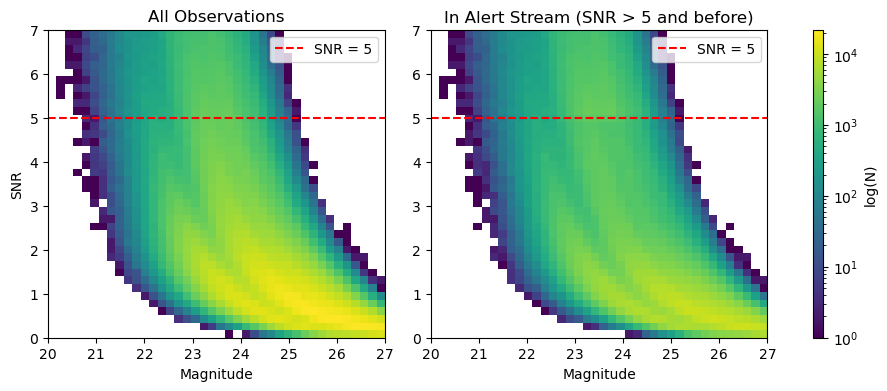

In [10]:
x_bins = 40
y_bins = 40
x_range = [20, 27]
y_range = [0, 7]
bins = [x_bins, y_bins]
range_ = [x_range, y_range]


# Compute 2D histograms manually

H1, _, _ = np.histogram2d(df_phot['magnitude'], df_phot['SNR'],
                          bins=bins, range=range_)
H2, _, _ = np.histogram2d(df_phot_in_stream['magnitude'], df_phot_in_stream['SNR'],
                          bins=bins, range=range_)

# Determine global vmin and vmax for LogNorm (exclude zeros)
nonzero_counts = np.concatenate([H1.ravel(), H2.ravel()])
nonzero_counts = nonzero_counts[nonzero_counts > 0]
vmin = nonzero_counts.min()
vmax = nonzero_counts.max()

# Create figure with 3 subplots: 2 main plots + 1 thin colorbar subplot
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# First heatmap (left)
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(H1.T, origin='lower',
                 extent=[*x_range, *y_range],
                 aspect='auto', cmap='viridis',
                 norm=LogNorm(vmin=vmin, vmax=vmax))
ax1.set_title('All Observations')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('SNR')
ax1.axhline(y=5, color='r', linestyle='--', label='SNR = 5')
ax1.legend()

# Second heatmap (middle)
ax2 = fig.add_subplot(gs[1], sharey=ax1)
im2 = ax2.imshow(H2.T, origin='lower',
                 extent=[*x_range, *y_range],
                 aspect='auto', cmap='viridis',
                 norm=LogNorm(vmin=vmin, vmax=vmax))
ax2.set_title('In Alert Stream (SNR > 5 and before)')
ax2.set_xlabel('Magnitude')
ax2.axhline(y=5, color='r', linestyle='--', label='SNR = 5')
ax2.legend()

# Colorbar subplot (right, very thin)
cax = fig.add_subplot(gs[2])
cbar = fig.colorbar(im2, cax=cax)
cbar.set_label('log(N)')

plt.tight_layout()
plt.show()


### How much later are we detecting the light-curves?

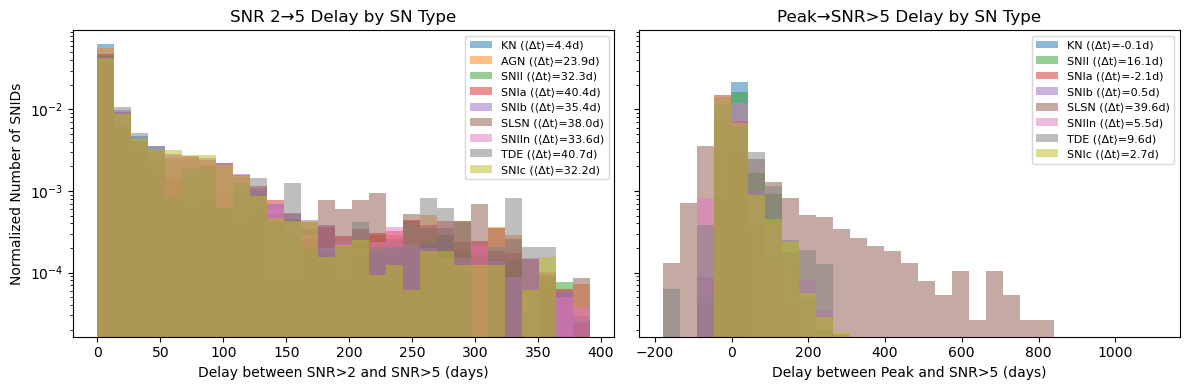

In [11]:

# Merge SNR photometry with SN type
df_merged = df_phot_in_stream.merge(
    df_header[['SNID', 'SN_TYPE_FROM_PATH',"PEAKMJD"]], on='SNID', how='left'
)

# Get first MJD for SNR > 2 and SNR > 5
first_snr2 = df_merged[df_merged['SNR'] > 2].groupby('SNID')['MJD'].min().rename('first_snr2')
first_snr5 = df_merged[df_merged['SNR'] > 5].groupby('SNID')['MJD'].min().rename('first_snr5')
peakmjd = df_merged.groupby('SNID')['PEAKMJD'].min().rename('peakmjd')

# Merge and compute delays
snr_df = pd.concat([first_snr2, first_snr5, peakmjd], axis=1).dropna()
snr_df['delay_snr25'] = snr_df['first_snr5'] - snr_df['first_snr2']
snr_df['delay_peaksnr5'] = (snr_df['first_snr5'] - snr_df['peakmjd']).where(snr_df['peakmjd'] > 0, np.nan)

# Add SN_TYPE_FROM_PATH
snr_df = snr_df.merge(df_header[['SNID', 'SN_TYPE_FROM_PATH']], on='SNID', how='left')

# Prepare plotting
sn_types = snr_df['SN_TYPE_FROM_PATH'].unique()
colors = plt.cm.tab10.colors

# Define common bins
bins1 = np.linspace(0, snr_df['delay_snr25'].max(), 30)
bins2 = np.linspace(snr_df['delay_peaksnr5'].min(), snr_df['delay_peaksnr5'].max(), 30)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot delay_snr25
for i, sn_type in enumerate(sn_types):
    subset = snr_df[snr_df['SN_TYPE_FROM_PATH'] == sn_type]
    mean_delay = subset['delay_snr25'].mean()
    axes[0].hist(
        subset['delay_snr25'],
        bins=bins1,
        alpha=0.5,
        label=f"{sn_type} (⟨Δt⟩={mean_delay:.1f}d)",
        color=colors[i % len(colors)],
        density=True
    )
axes[0].set_xlabel('Delay between SNR>2 and SNR>5 (days)')
axes[0].set_ylabel('Normalized Number of SNIDs')
axes[0].set_title('SNR 2→5 Delay by SN Type')
axes[0].set_yscale('log')
axes[0].legend(fontsize=8)

# Plot delay_peaksnr5
for i, sn_type in enumerate(sn_types):
    if sn_type in ['KN','TDE'] or 'SN' in sn_type:
        subset = snr_df[snr_df['SN_TYPE_FROM_PATH'] == sn_type]
        mean_delay = subset['delay_peaksnr5'].mean()
        axes[1].hist(
            subset['delay_peaksnr5'],
            bins=bins2,
            alpha=0.5,
            label=f"{sn_type} (⟨Δt⟩={mean_delay:.1f}d)",
            color=colors[i % len(colors)],
            density=True
        )
axes[1].set_xlabel('Delay between Peak and SNR>5 (days)')
axes[1].set_title('Peak→SNR>5 Delay by SN Type')
axes[1].set_yscale('log')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()


# How do broker light-curves actually look like?

In [12]:
def plot_lc_subplots(df_phot, df_header, idx, inmag=False, convert_date=False):

    # select data for the given SNID
    sel_phot = df_phot[df_phot.SNID == idx].copy()
    sel_header = df_header[df_header.SNID == idx]

    #restrict to positive magnitudes if inmag
    if inmag:
        sel_phot = sel_phot[sel_phot["magnitude"] > 0]

    # how many bands for this light-curve?
    sel_phot["BAND"] = sel_phot["BAND"].str.decode('utf-8').str.strip()
    bands = sel_phot["BAND"].unique()

    if convert_date:
        sel_phot["TIME"] = pd.to_datetime(sel_phot["MJD"], unit='D', origin='1858-11-17')
        x_col = "TIME"
    else:
        x_col = "MJD"

    # For this SNID get peakMJD
    peakmjd = float(sel_header.PEAKMJD.values[0])
    if convert_date:
        peak_x = pd.to_datetime(peakmjd, unit='D', origin='1858-11-17')
    else:
        peak_x = peakmjd
    # For this SNID get latest detection MJD
    snr5_df = sel_phot[sel_phot['SNR'] > 5]
    last_alert_mjd = snr5_df.groupby('SNID')['MJD'].max()
    snr5_sorted = snr5_df.sort_values('MJD')

    #
    # Create datasets as alerts by broker
    #
    # 1st SNR>5 detection
    sel_phot_1 = snr5_sorted.head(1)
    # 2nd SNR>5 detection
    if len(snr5_sorted) >= 2:
        second_snr5_mjd = snr5_sorted.iloc[1]['MJD']
        # add forced photometry if the second SNR > 5 detection is more than 1 day after the first
        if second_snr5_mjd-snr5_sorted.iloc[0]['MJD']>1:
            snr_lt5_before_second = sel_phot[(sel_phot['SNR'] < 5) & (sel_phot['MJD'] < second_snr5_mjd)]
            sel_phot_2 = pd.concat([snr5_sorted.head(2), snr_lt5_before_second])
        else: # use SNR>5 only
            sel_phot_2 = snr5_sorted.head(2)
    # If there is no second SNR > 5 detection, dont' plot it
    else:
        sel_phot_2 = pd.DataFrame()
    # 3rd SNR > 5 detection
    if len(snr5_sorted) >= 3:
        third_mjd = snr5_sorted.iloc[2]['MJD']
        if third_mjd-snr5_sorted.iloc[0]['MJD']>1:
            sel_phot_2_5 = sel_phot[sel_phot['MJD'] <= third_mjd]
            # add forced photometry
            tmp = sel_phot[(sel_phot['SNR'] < 5) & (sel_phot['MJD'] < second_snr5_mjd)]
            sel_phot_2_5 = pd.concat([snr5_sorted.head(3), tmp])
        else: 
            sel_phot_2_5 = snr5_sorted.head(3)
    else:
        sel_phot_2_5 = pd.DataFrame()
    # All SNR>5 detections
    if len(snr5_sorted) > 2:
        third_snr5_mjd = snr5_sorted.iloc[-1]['MJD']
        if third_snr5_mjd-snr5_sorted.iloc[0]['MJD']>1:
            # add forced photometry if the next SNR > 5 detection is more than 1 day after the first
            snr_lt5_before_last = sel_phot[(sel_phot['SNR'] < 5) & (sel_phot['MJD'] < third_snr5_mjd)]
            sel_phot_3 = pd.concat([snr5_sorted, snr_lt5_before_last])
        else:
            sel_phot_3 = snr5_sorted
    else:
        # no plot?
        sel_phot_3 = pd.DataFrame() #sel_phot
    # Full light curve with all data
    sel_phot_4 = sel_phot.copy()

    fig = make_subplots(rows=1, cols=4, subplot_titles=[
        "1. First SNR > 5",
        "2. Second SNR > 5",
        "3. All broker data (w forced phot)",
        "4. Full lc (w/wo broker det)"
    ])
    datasets = [sel_phot_1, sel_phot_2, sel_phot_2_5, sel_phot_3, sel_phot_4]

    # Compute titles with latest detection MJD or date
    subplot_titles = []
    for i, df in enumerate([sel_phot_1, sel_phot_2, sel_phot_2_5, sel_phot_3, sel_phot_4]):
        if df.empty:
            latest = "No data"
        else:
            latest_mjd = df['MJD'].max()
            if convert_date:
                latest = pd.to_datetime(latest_mjd, unit='D', origin='1858-11-17').strftime('%Y-%m-%d')
            else:
                latest = f"MJD {latest_mjd:.1f}"
        
        base_title = [
            "1. First SNR > 5",
            "2. Second SNR > 5",
            "2.5. Up to Third SNR > 5",
            "3. All broker data (w/ forced phot)",
            "4. Full LC"
        ][i]
        
        subplot_titles.append(f"{base_title}<br>Latest: {latest}")

    # general values
    z = np.round(float(sel_header.REDSHIFT_FINAL.values[0]), 2)
    sim_type_name = sel_header.SIM_TYPE_NAME.values[0]
    if isinstance(sim_type_name, bytes):
        sim_type_name = sim_type_name.decode("utf-8")
    if sel_header.in_ddf_field.values[0]:
        ddf_field_name = sel_header.ddf_field_name.values[0]
    else:
        ddf_field_name = "Not in DDF"

    # finally plot
    fig = make_subplots(rows=1, cols=5, subplot_titles=subplot_titles)
    for i, dataset in enumerate(datasets):
        # Non empty datasets only
        if len(dataset)>0:
            for flt in bands:
                sel_flt = dataset[dataset["BAND"] == flt]

                if inmag:
                    yvar = "magnitude"
                    yerrvar = "magnitude error"
                else:
                    yvar = "FLUXCAL"
                    yerrvar = "FLUXCALERR"

                for snr_min, snr_max, symbol, opacity, name_suffix in [
                    (5, np.inf, 'circle', 1, "SNR > 5"),
                    (1, 5, 'square', 0.3, "1 < SNR < 5"),
                ]:
                    mask = (sel_flt['SNR'] > snr_min) & (sel_flt['SNR'] < snr_max)
                    fig.add_trace(go.Scatter(
                        x=sel_flt.loc[mask, x_col],
                        y=sel_flt.loc[mask, yvar],
                        error_y=dict(
                            type='data',
                            array=sel_flt.loc[mask, yerrvar],
                            visible=True,
                            thickness=1.5 if snr_min < 5 else None,
                            width=0.5 if snr_min < 5 else None,
                        ),
                        mode='markers',
                        name=f"{flt}" if (snr_min == 5 and i==4) else None,
                        showlegend=(snr_min == 5 and i==4),  # hides legend when name is None
                        marker=dict(opacity=opacity, symbol=symbol, size=8, color=band_colors.get(flt, 'black')),
                        # showlegend=(i == 0)
                    ), row=1, col=i+1)

                # SNR < 1 points
                mask = sel_flt['SNR'] < 1
                fig.add_trace(go.Scatter(
                    x=sel_flt.loc[mask, x_col],
                    y=sel_flt.loc[mask, yvar],
                    mode='markers',
                    showlegend=False,
                    marker=dict(opacity=0.2, symbol='triangle-down', size=8, color=band_colors.get(flt, 'black')),
                ), row=1, col=i+1)
            
            # Vertical line for PEAKMJD
            if 'AGN' not in sim_type_name:
                fig.add_vline(
                    x=peak_x,
                    line=dict(color="black", width=1, dash="dash"),
                    row=1, col=i+1
                )
            # Add vertical line for first SNR > 5 detection
            snr5_in_dataset = dataset[dataset['SNR'] > 5]
            if not snr5_in_dataset.empty:
                first_snr5_mjd = snr5_in_dataset['MJD'].min()
                first_snr5_x = pd.to_datetime(first_snr5_mjd, unit='D', origin='1858-11-17') if convert_date else first_snr5_mjd
                fig.add_vline(
                    x=first_snr5_x,
                    line=dict(color="blue", width=1.5, dash="dot"),
                    row=1, col=i+1
                )
        # for the last two panels add line for last SNR > 5 detection
        if i > 2 and not snr5_sorted.empty:
            last_snr5_mjd = snr5_sorted['MJD'].max()
            last_snr5_x = pd.to_datetime(last_snr5_mjd, unit='D', origin='1858-11-17') if convert_date else last_snr5_mjd
            fig.add_vline(
                x=last_snr5_x,
                line=dict(color="red", width=1.5, dash="dash"),
                row=1, col=i+1
            )

    else:
        ddf_field_name = "Not in DDF"
    


    ylabel = "magnitude" if inmag else "FLUXCAL"
    fig.update_layout(
        title_text=f"SNID: {idx} SNTYPE: {sim_type_name} z: {z} {ddf_field_name}",
        height=400,
        width=1500,  # increased width for 5 panels
        legend_title="Filter"
    )


    fig.update_yaxes(title_text=ylabel, autorange="reversed")
    fig.update_xaxes(title_text="Date" if convert_date else "MJD")
    fig.show()


In [13]:
# By types
for sntyp in df_header['SN_TYPE_FROM_PATH'].unique():
    print(f"Plotting light curves for type: {sntyp}")
    snids = df_header[df_header['SN_TYPE_FROM_PATH'] == sntyp]['SNID'].unique()
    for snid in snids:
        if len(df_phot[df_phot['SNID'] == snid]) > 5: # ask 5 photometric points
            plot_lc_subplots(df_phot, df_header, snid, inmag=True, convert_date=True)
            break  # Stop after first successful plot for this type

Plotting light curves for type: AGN


Plotting light curves for type: SNIIn


Plotting light curves for type: SNIc


Plotting light curves for type: SNIb


Plotting light curves for type: SLSN


Plotting light curves for type: KN


Plotting light curves for type: SNII


Plotting light curves for type: SNIa


Plotting light curves for type: TDE


# In Deep Drilling Fields

- "one pointing" (actually several with dithering) + Euclid has two pointings... 
- 1st year will have a dense cadence to achieve deep templates... a challenge for brokers!

In [14]:
# DDF
for snid in df_header[(df_header.in_ddf_field) & (df_header.SNID.isin(df_phot.SNID.values))]['SNID'].unique()[:5]:
    plot_lc_subplots(df_phot,df_header, snid, inmag=True,convert_date=True)


In [15]:
for snid in df_header[(df_header.SNID.isin(df_phot.SNID.values))]['SNID'].unique()[:10]:

    # Call your plotting function
    plot_lc_subplots(df_phot,df_header, snid, inmag=True,convert_date=True)


# Many challenges

### - We will only have  parts of the light-curves, which science cases can be done early and up to latest SNR>5?

### - What to do when there are so many data points in an observing night
#### Visualisation and ML algorithms
  - mean per night (not all detections are SNR>5) with or without forced photometry?
  - last alert
  - all of them (several ML algorithms?)

In [16]:
print('What else?')

What else?
